# business Problem

#### Objetivo do Problema
    -- Previsão do primeiro destino que um novo usuario irá escolher.

#### Porque?
**Qual tipo de modelo de negócio do AirBNB?**
    
    -- MarketPlace (Conecta pessoas que oferecem acomodação, com pessoas que estão procurando acomodação).

##### Oferta (Pessoas oferecendo acomodação)

    -- Tamanho do portfolio
    -- Diversidade/densidade de portfolio
    -- Preço medio

##### Demanda (Pessoas procurando acomodação)

    -- Numero de usuarios
    -- LTV (Lifitime Value)
    -- CAC (Client Acquisition Cost)

**Cross Revenue** (FEE * Numero Cliente) - CAC

#### Proposta da Solução

    -- Modelo de predição do primeiro destino de um novo usuario.

##### Tipos de formatos para entrega do projeto.
    -- Predições salva em tabela do banco de dados.
    -- API: Input: Usuario e suas caracteristicas / Output: Usuario e suas caracteristicas com as Predições do destino.

# Ciclo05: Balanced Dataset

# 00 - Imports

In [339]:
import pandas as pd
import random
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt

from keras import models as ml
from keras import layers as l

import warnings
import pickle

warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML(""))

## Functions

In [224]:
def drescriptive_statistical (df):

    num_atributes = df.copy()
    #Central Tendency - mean - median
    ct1 = pd.DataFrame(num_atributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_atributes.apply(np.median)).T

    #Dispersion - STD, min, max, range, sken, Kurtosis
    d1 = pd.DataFrame(num_atributes.apply(np.std)).T
    d2 = pd.DataFrame(num_atributes.apply(min)).T
    d3 = pd.DataFrame(num_atributes.apply(max)).T
    d4 = pd.DataFrame(num_atributes.apply(lambda x: x.max() - x.min() )).T
    d5 = pd.DataFrame(num_atributes.apply(lambda x: x.skew() )).T
    d6 = pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis() )).T

    #Concatenate

    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m


def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    jupyter_settings()


#Function Calculates cramer V
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - ( k - 1 ) * ( r - 1) / (n - 1))
    kcorr = k - (k - 1) **2/(n - 1) 
    rcorr = r - (r - 1) **2/(n - 1)
    
    return np.sqrt( (chi2corr / n) / (min(kcorr -1, rcorr -1) ) )

## Paths

In [225]:
path_data = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/data/'
path_model = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/models/'
path_transformation = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_first_booking/airbnb_predict_first_booking/transformation_data/'

## Loading Data

|Feature Name| Information|
|----------------|:---------------:|
|id:                         |ID do Usuario
|date_account_created:       |Data da Criação da Conta
|timestamp_first_active:     |Data do primeira acesso, note que pode ser anterior à data de criação da conta ou à data da primeira reserva porque um utilizador pode pesquisar antes de se inscrever
|date_first_booking:         |data da primeira reserva
|gender                      |Sexo
|age                         |Idade 
|signup_method               |Metodo de inscrição
|signup_flow:                |fluxo de inscrição: a página de onde um utilizador veio para se inscrever
|language:                   |Preferencia linguistica internacional
|affiliate_channel:          |canal afiliado: que tipo de marketing pago
|affiliate_provider:         |fornecedor afiliado: onde o marketing é, por exemplo, google, craigslist, outro
|first_affiliate_tracked:    |primeira afiliação rastreada: qual foi o primeiro marketing com que o utilizador interagiu antes da inscrição
|signup_app                  |Aplicativo de inscrição
|first_device_type           |Primeiro tipo de dispositivo
|first_browser               |Primeiro nagevagor
|country_destination:        |Destino do pai:Variavel alvo que deve prever


In [226]:
data = pd.read_csv(path_data+'train_users_2.csv')
data1 = pd.read_csv(path_data+ 'sessions.csv')

In [227]:
data.head(1).T

,0
id,gxn3p5htnn
date_account_created,2010-06-28
timestamp_first_active,20090319043255
date_first_booking,NaN
gender,-unknown-
age,NaN
signup_method,facebook
signup_flow,0
language,en
affiliate_channel,direct


In [228]:
data1.head(1).T

,0
user_id,d1mm9tcy42
action,lookup
action_type,NaN
action_detail,NaN
device_type,Windows Desktop
secs_elapsed,319.0


# 1.0 Data Description

## Data Dimensions

In [229]:
print("Number of Rows {}".format(data.shape[0]))
print("Number of Rows {}".format(data.shape[1])) 

Number of Rows 213451
Number of Rows 16


In [230]:
print("Number of Rows {}".format(data1.shape[0]))
print("Number of Rows {}".format(data1.shape[1]))

Number of Rows 10567737
Number of Rows 6


## Data Types

In [231]:
data.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [232]:
data1.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## Check NA

In [233]:
data.isnull().sum() / len(data)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [234]:
data1.isnull().sum() / len(data1)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## Treatment NA

### train_users_2.csv (data)

In [235]:
#date_first_booking (Primeiro book do cliente)

aux = data[data['date_first_booking'].isna()]
aux['country_destination'].value_counts(normalize=True)

#Transformand os NAs na data maxima do date_first_booking.
date_first_booking_max = pd.to_datetime(data['date_first_booking']).max().strftime('%Y-%m-%d')
data['date_first_booking'] = data['date_first_booking'].fillna(date_first_booking_max)


In [236]:
aux['country_destination'].value_counts(normalize=True)


NDF    1.0
Name: country_destination, dtype: float64

NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64


<AxesSubplot:xlabel='age', ylabel='Density'>

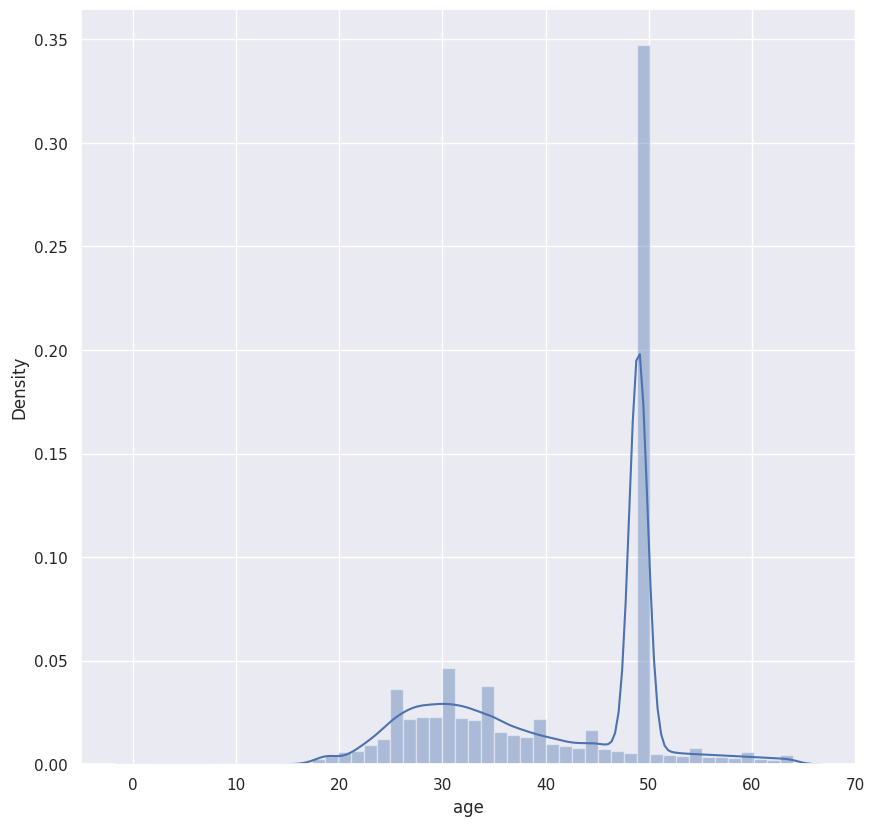

In [237]:
#Column Age

#data['age'].describe()

aux1 = data[data['age'].isna()]
print(aux1['country_destination'].value_counts(normalize=True))

data['age'] = data['age'].fillna(data['age'].mean()).astype(int)
sns.distplot(data[data['age'] < 65]['age'])


In [238]:
#first_affiliate_tracked

aux2 = data[data['first_affiliate_tracked'].isna()]
aux2['country_destination'].value_counts(normalize=True)

#Neste variavel temos apenas 3% de dados faltantes, neste caso por ser dados categoricos, prefiro jogar fora do que tentar substituir e acabar inputando um viés nos dados.

data = data[~data['first_affiliate_tracked'].isna()]

### sessions.csv (data1)

In [239]:
#user_id          0.003264
data1 = data1[~data1['user_id'].isna()]

#action           0.007535
data1 = data1[~data1['action'].isna()]

#action_type      0.106570
data1 = data1[~data1['action_type'].isna()]

#action_detail    0.106570
data1 = data1[~data1['action_detail'].isna()]

#device_type      0.000000
data1 = data1[~data1['device_type'].isna()]

#secs_elapsed     0.012872
data1 = data1[~data1['secs_elapsed'].isna()]

## Change data type

In [240]:
#date_account_created 
data['date_account_created'] = pd.to_datetime( data['date_account_created'] )

#timestamp_first_active
data['timestamp_first_active'] = pd.to_datetime(data['timestamp_first_active'], format='%Y%m%d%H%M%S')
data['timestamp_first_active'] = pd.to_datetime(data['timestamp_first_active'].dt.strftime('%y-%m-%d-'))

#date_first_booking
data['date_first_booking'] = pd.to_datetime(data['date_first_booking'])

#age
data['age'] = data['age'].astype(int)


In [241]:
data.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [242]:
data.sample()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
213011,fuh4l609ir,2014-06-30,2030-06-14,2014-06-30,-unknown-,49,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,US


### Check Balanced Data

In [243]:
data['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

Classe resposta bem desbalanceada, vamos seguir dessa forma para finalizarmos o pipeline com o primeiro ciclo de crisp

# 2.0 Descriptive Statistics

In [244]:
num_atributes = data.select_dtypes( include=['int64', 'float64'])
cat_atributes = data.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

num_atributes_session = data1.select_dtypes( include=['int64', 'float64'])
cat_atributes_session = data1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Atributes

In [245]:
# Data users
drescriptive_statistical(num_atributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,1.0,2014.0,2013.0,49.183142,49.0,118.421689,16.333820,267.655434
1,signup_flow,0.0,25.0,25.0,3.151490,0.0,7.543915,2.287158,3.567794


In [246]:
# Data Session
drescriptive_statistical(num_atributes_session)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


# 3.0 Feature Engineering

## 3.1 Mapa Mental

## 3.2 Criação das Hipóteses

## 3.3 Derivação de Novas Features

In [247]:
data.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2019-09-03,2015-06-29,-unknown-,49,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2023-09-05,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-09-06,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2031-09-10,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2008-09-12,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [248]:
#Days from fisrt active up to first booking
data['days_from _first_active_until_booking'] = (data['date_first_booking'] - data['timestamp_first_active']).apply(lambda x: x.days)
data['days_from _first_active_until_booking'] = (data['days_from _first_active_until_booking']).apply(lambda x: 0 if x < 0 else x)

#Days from first active upt to account created
data['days_from _first_active_until_account_created'] = (data['timestamp_first_active'] - data['date_account_created']).apply(lambda x: x.days)
data['days_from _first_active_until_account_created'] = (data['days_from _first_active_until_account_created']).apply(lambda x: 0 if x < 0 else x )

#Days from account created up to first boooking
data['days_from _account_created_until_booking'] = (data['date_first_booking'] - data['date_account_created']).apply(lambda x: x.days)
data['days_from _account_created_until_booking'] = (data['days_from _account_created_until_booking']).apply(lambda x: 0 if x < 0 else x)

#year
data['date_account_created_year'] = data['date_account_created'].dt.year
data['timestamp_first_active_year'] = data['timestamp_first_active'].dt.year
data['date_first_booking_year'] = data['date_first_booking'].dt.year

#month
data['date_account_created_month'] = data['date_account_created'].dt.month
data['timestamp_first_active_month'] = data['timestamp_first_active'].dt.month
data['date_first_booking_month'] = data['date_first_booking'].dt.month

#week
data['date_account_created_week'] = data['date_account_created'].dt.weekday
data['timestamp_first_active_week'] = data['timestamp_first_active'].dt.weekday
data['date_first_booking_week'] = data['date_first_booking'].dt.weekday

#days
data['date_account_created_day'] = data['date_account_created'].dt.day
data['timestamp_first_active_day'] = data['timestamp_first_active'].dt.day
data['date_first_booking_day'] = data['date_first_booking'].dt.day

#Drop date
coldrop = ['date_account_created', 'timestamp_first_active', 'date_first_booking'] #original datetime

data = data.drop(coldrop, axis=1)

# 4.0 Data Filtering

## 4.1 Num_atributes

### Filtering Rows - Date Users

### Age

<AxesSubplot:xlabel='age', ylabel='Density'>

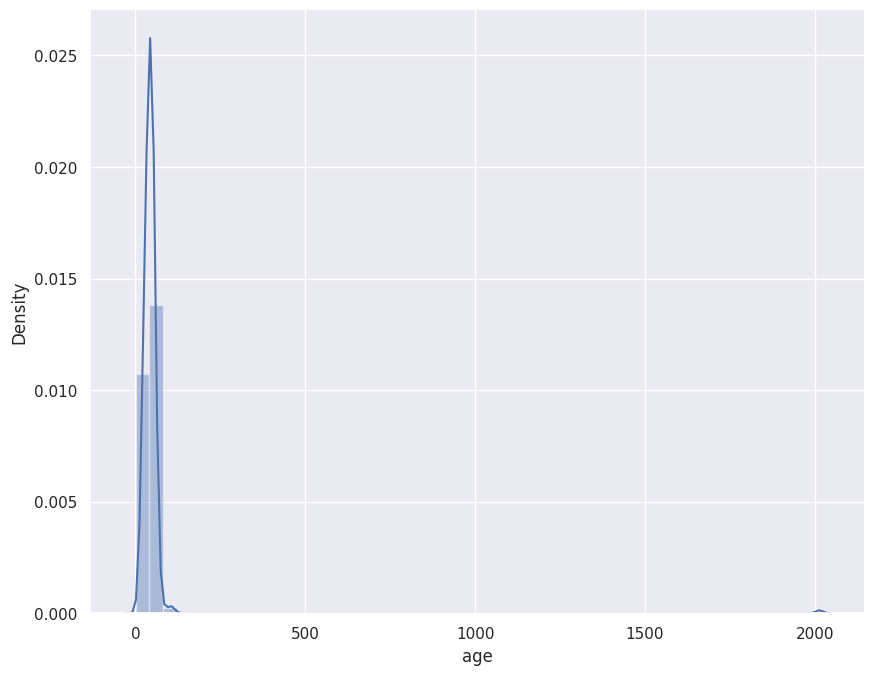

In [191]:
plt.figure(figsize = (10,8 ))
sns.distplot(data['age']) 

<AxesSubplot:xlabel='age'>

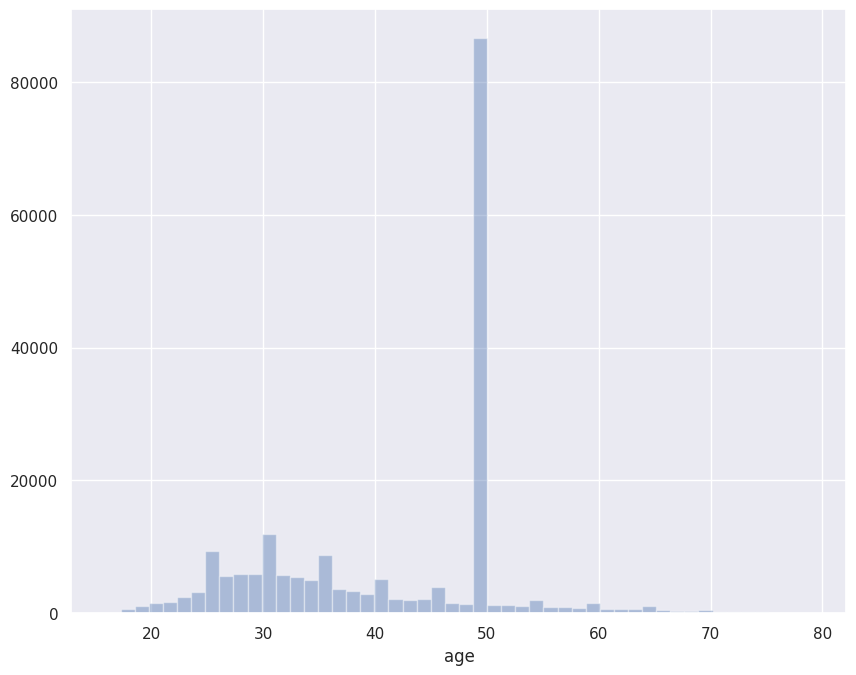

In [192]:
age_aux = data[(data['age'] > 15) & (data['age'] < 80)]

plt.figure(figsize = (10,8 ))
sns.distplot(age_aux['age'], kde=False) 

In [193]:
#Verificando as pessoas com idade > 80 em relação a variavel resposta
age_aux1 = data[data['age'] > 80][['age', 'country_destination']]
age_aux1.groupby('country_destination').size() / len(aux)

#Analisando os clientes com mais de 80 anos, podemos notar que existe uma distribuição desbalanceada entre as classes. Lembrando que todos os nossos dados esta com este
#mesmo desbalanceamento. Neste caso faz algum sentido essas idades em nossos dados e vamos assumir que clientes acima de 15 e abaixo de 120 esteja corretos em nossos dados. 
#Importante na decisão de corte de dados seria manter as mesmas proporções entre as classes, para criarmos vies ao modelo.

country_destination
AU       0.000064
CA       0.000185
DE       0.000136
ES       0.000257
FR       0.000514
GB       0.000337
IT       0.000458
NDF      0.010149
NL       0.000104
PT       0.000016
US       0.008061
other    0.001477
dtype: float64

<AxesSubplot:xlabel='age'>

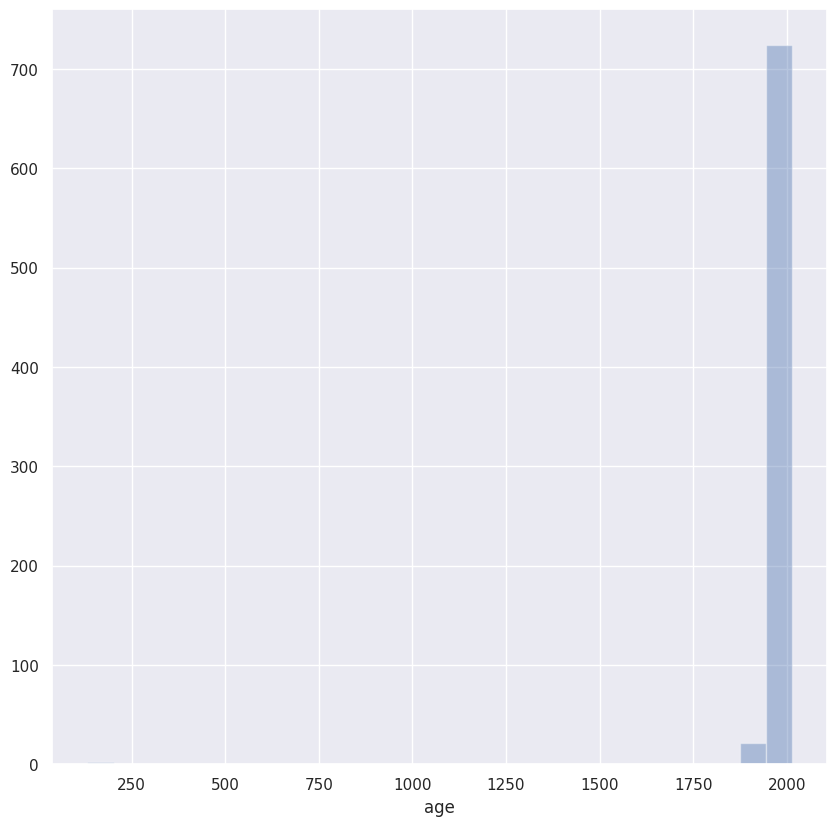

In [194]:
sns.distplot(data[data['age'] > 120]['age'], kde=False) 

In [250]:
# Filtering rows:
# age - greater than 15 and lower that 120 - There are few people over 120 years old.

data = data[(data['age'] > 15 ) & (data['age'] < 120)]

### Filtering Rows - Date Session

In [252]:
# secs_elapsed

#Essa feature nos tras as informações de quanto tempo o cliente permaneceu no site, estranhamente temos tempo = 0

data1 = data1[data1['secs_elapsed'] > 0]

## 4.2 Cat_atributes

### Data User

In [197]:
from pandas_profiling import ProfileReport

profile = ProfileReport(cat_atributes)

In [198]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [199]:
import sweetviz as sv
my_report = sv.analyze(cat_atributes)
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [200]:
cat_atributes.describe().T

,count,unique,top,freq
id,207386,207386,gxn3p5htnn,1
gender,207386,4,-unknown-,91783
signup_method,207386,3,basic,148297
language,207386,25,en,200415
affiliate_channel,207386,8,direct,134179
affiliate_provider,207386,18,direct,133935
first_affiliate_tracked,207386,7,untracked,109232
signup_app,207386,4,Web,178334
first_device_type,207386,9,Mac Desktop,89600
first_browser,207386,52,Chrome,63845


In [201]:
a1  = cramer_v(cat_atributes['gender'], cat_atributes['gender'])
a2  = cramer_v(cat_atributes['gender'], cat_atributes['signup_method'])
a3  = cramer_v(cat_atributes['gender'], cat_atributes['language'])
a4  = cramer_v(cat_atributes['gender'], cat_atributes['affiliate_channel'])
a5  = cramer_v(cat_atributes['gender'], cat_atributes['affiliate_provider'])
a6  = cramer_v(cat_atributes['gender'], cat_atributes['first_affiliate_tracked'])
a7  = cramer_v(cat_atributes['gender'], cat_atributes['signup_app'])
a8  = cramer_v(cat_atributes['gender'], cat_atributes['first_device_type'])
a9  = cramer_v(cat_atributes['gender'], cat_atributes['first_browser'])
a10 = cramer_v(cat_atributes['gender'], cat_atributes['country_destination'])

b1  = cramer_v(cat_atributes['signup_method'], cat_atributes['gender'])
b2  = cramer_v(cat_atributes['signup_method'], cat_atributes['signup_method'])
b3  = cramer_v(cat_atributes['signup_method'], cat_atributes['language'])
b4  = cramer_v(cat_atributes['signup_method'], cat_atributes['affiliate_channel'])
b5  = cramer_v(cat_atributes['signup_method'], cat_atributes['affiliate_provider'])
b6  = cramer_v(cat_atributes['signup_method'], cat_atributes['first_affiliate_tracked'])
b7  = cramer_v(cat_atributes['signup_method'], cat_atributes['signup_app'])
b8  = cramer_v(cat_atributes['signup_method'], cat_atributes['first_device_type'])
b9  = cramer_v(cat_atributes['signup_method'], cat_atributes['first_browser'])
b10 = cramer_v(cat_atributes['signup_method'], cat_atributes['country_destination'])

c1  = cramer_v(cat_atributes['language'], cat_atributes['gender'])
c2  = cramer_v(cat_atributes['language'], cat_atributes['signup_method'])
c3  = cramer_v(cat_atributes['language'], cat_atributes['language'])
c4  = cramer_v(cat_atributes['language'], cat_atributes['affiliate_channel'])
c5  = cramer_v(cat_atributes['language'], cat_atributes['affiliate_provider'])
c6  = cramer_v(cat_atributes['language'], cat_atributes['first_affiliate_tracked'])
c7  = cramer_v(cat_atributes['language'], cat_atributes['signup_app'])
c8  = cramer_v(cat_atributes['language'], cat_atributes['first_device_type'])
c9  = cramer_v(cat_atributes['language'], cat_atributes['first_browser'])
c10 = cramer_v(cat_atributes['language'], cat_atributes['country_destination'])

d1  = cramer_v(cat_atributes['affiliate_channel'], cat_atributes['gender'])
d2  = cramer_v(cat_atributes['affiliate_channel'], cat_atributes['signup_method'])
d3  = cramer_v(cat_atributes['affiliate_channel'], cat_atributes['language'])
d4  = cramer_v(cat_atributes['affiliate_channel'], cat_atributes['affiliate_channel'])
d5  = cramer_v(cat_atributes['affiliate_channel'], cat_atributes['affiliate_provider'])
d6  = cramer_v(cat_atributes['affiliate_channel'], cat_atributes['first_affiliate_tracked'])
d7  = cramer_v(cat_atributes['affiliate_channel'], cat_atributes['signup_app'])
d8  = cramer_v(cat_atributes['affiliate_channel'], cat_atributes['first_device_type'])
d9  = cramer_v(cat_atributes['affiliate_channel'], cat_atributes['first_browser'])
d10 = cramer_v(cat_atributes['affiliate_channel'], cat_atributes['country_destination'])

e1  = cramer_v(cat_atributes['affiliate_provider'], cat_atributes['gender'])
e2  = cramer_v(cat_atributes['affiliate_provider'], cat_atributes['signup_method'])
e3  = cramer_v(cat_atributes['affiliate_provider'], cat_atributes['language'])
e4  = cramer_v(cat_atributes['affiliate_provider'], cat_atributes['affiliate_channel'])
e5  = cramer_v(cat_atributes['affiliate_provider'], cat_atributes['affiliate_provider'])
e6  = cramer_v(cat_atributes['affiliate_provider'], cat_atributes['first_affiliate_tracked'])
e7  = cramer_v(cat_atributes['affiliate_provider'], cat_atributes['signup_app'])
e8  = cramer_v(cat_atributes['affiliate_provider'], cat_atributes['first_device_type'])
e9  = cramer_v(cat_atributes['affiliate_provider'], cat_atributes['first_browser'])
e10 = cramer_v(cat_atributes['affiliate_provider'], cat_atributes['country_destination'])

f1  = cramer_v(cat_atributes['first_affiliate_tracked'], cat_atributes['gender'])
f2  = cramer_v(cat_atributes['first_affiliate_tracked'], cat_atributes['signup_method'])
f3  = cramer_v(cat_atributes['first_affiliate_tracked'], cat_atributes['language'])
f4  = cramer_v(cat_atributes['first_affiliate_tracked'], cat_atributes['affiliate_channel'])
f5  = cramer_v(cat_atributes['first_affiliate_tracked'], cat_atributes['affiliate_provider'])
f6  = cramer_v(cat_atributes['first_affiliate_tracked'], cat_atributes['first_affiliate_tracked'])
f7  = cramer_v(cat_atributes['first_affiliate_tracked'], cat_atributes['signup_app'])
f8  = cramer_v(cat_atributes['first_affiliate_tracked'], cat_atributes['first_device_type'])
f9  = cramer_v(cat_atributes['first_affiliate_tracked'], cat_atributes['first_browser'])
f10 = cramer_v(cat_atributes['first_affiliate_tracked'], cat_atributes['country_destination'])

g1  = cramer_v(cat_atributes['signup_app'], cat_atributes['gender'])
g2  = cramer_v(cat_atributes['signup_app'], cat_atributes['signup_method'])
g3  = cramer_v(cat_atributes['signup_app'], cat_atributes['language'])
g4  = cramer_v(cat_atributes['signup_app'], cat_atributes['affiliate_channel'])
g5  = cramer_v(cat_atributes['signup_app'], cat_atributes['affiliate_provider'])
g6  = cramer_v(cat_atributes['signup_app'], cat_atributes['first_affiliate_tracked'])
g7  = cramer_v(cat_atributes['signup_app'], cat_atributes['signup_app'])
g8  = cramer_v(cat_atributes['signup_app'], cat_atributes['first_device_type'])
g9  = cramer_v(cat_atributes['signup_app'], cat_atributes['first_browser'])
g10 = cramer_v(cat_atributes['signup_app'], cat_atributes['country_destination'])

h1  = cramer_v(cat_atributes['first_device_type'], cat_atributes['gender'])
h2  = cramer_v(cat_atributes['first_device_type'], cat_atributes['signup_method'])
h3  = cramer_v(cat_atributes['first_device_type'], cat_atributes['language'])
h4  = cramer_v(cat_atributes['first_device_type'], cat_atributes['affiliate_channel'])
h5  = cramer_v(cat_atributes['first_device_type'], cat_atributes['affiliate_provider'])
h6  = cramer_v(cat_atributes['first_device_type'], cat_atributes['first_affiliate_tracked'])
h7  = cramer_v(cat_atributes['first_device_type'], cat_atributes['signup_app'])
h8  = cramer_v(cat_atributes['first_device_type'], cat_atributes['first_device_type'])
h9  = cramer_v(cat_atributes['first_device_type'], cat_atributes['first_browser'])
h10 = cramer_v(cat_atributes['first_device_type'], cat_atributes['country_destination'])

i1  = cramer_v(cat_atributes['first_browser'], cat_atributes['gender'])
i2  = cramer_v(cat_atributes['first_browser'], cat_atributes['signup_method'])
i3  = cramer_v(cat_atributes['first_browser'], cat_atributes['language'])
i4  = cramer_v(cat_atributes['first_browser'], cat_atributes['affiliate_channel'])
i5  = cramer_v(cat_atributes['first_browser'], cat_atributes['affiliate_provider'])
i6  = cramer_v(cat_atributes['first_browser'], cat_atributes['first_affiliate_tracked'])
i7  = cramer_v(cat_atributes['first_browser'], cat_atributes['signup_app'])
i8  = cramer_v(cat_atributes['first_browser'], cat_atributes['first_device_type'])
i9  = cramer_v(cat_atributes['first_browser'], cat_atributes['first_browser'])
i10 = cramer_v(cat_atributes['first_browser'], cat_atributes['country_destination'])

j1  = cramer_v(cat_atributes['country_destination'], cat_atributes['gender'])
j2  = cramer_v(cat_atributes['country_destination'], cat_atributes['signup_method'])
j3  = cramer_v(cat_atributes['country_destination'], cat_atributes['language'])
j4  = cramer_v(cat_atributes['country_destination'], cat_atributes['affiliate_channel'])
j5  = cramer_v(cat_atributes['country_destination'], cat_atributes['affiliate_provider'])
j6  = cramer_v(cat_atributes['country_destination'], cat_atributes['first_affiliate_tracked'])
j7  = cramer_v(cat_atributes['country_destination'], cat_atributes['signup_app'])
j8  = cramer_v(cat_atributes['country_destination'], cat_atributes['first_device_type'])
j9  = cramer_v(cat_atributes['country_destination'], cat_atributes['first_browser'])
j10 = cramer_v(cat_atributes['country_destination'], cat_atributes['country_destination'])




In [202]:
d = pd.DataFrame({  'gender':[a1,a2,a3,a4,a5,a6,a7,a8,a9,a10]
                    ,'signup_method':[b1,b2,b3,b4,b5,b6,b7,b8,b9,b10]
                    ,'language':[c1,c2,c3,c4,c5,c6,c7,c8,c9,c10]
                    ,'affiliate_channel':[d1,d2,d3,d4,d5,d6,d7,d8,d9,d10]
                    ,'affiliate_provider':[e1,e2,e3,e4,e5,e6,e7,e8,e9,e10]
                    ,'first_affiliate_tracked':[f1,f2,f3,f4,f5,f6,f7,f8,f9,f10]
                    ,'signup_app':[g1,g2,g3,g4,g5,g6,g7,g8,g9,g10]
                    ,'first_device_type':[h1,h2,h3,h4,h5,h6,h7,h8,h9,h10]
                    ,'first_browser':[i1,i2,i3,i4,i5,i6,i7,i8,i9,i10]
                    ,'country_destination':[j1,j2,j3,j4,j5,j6,j7,j8,j9,j10]})

d = d.set_index(d.columns)

<AxesSubplot:>

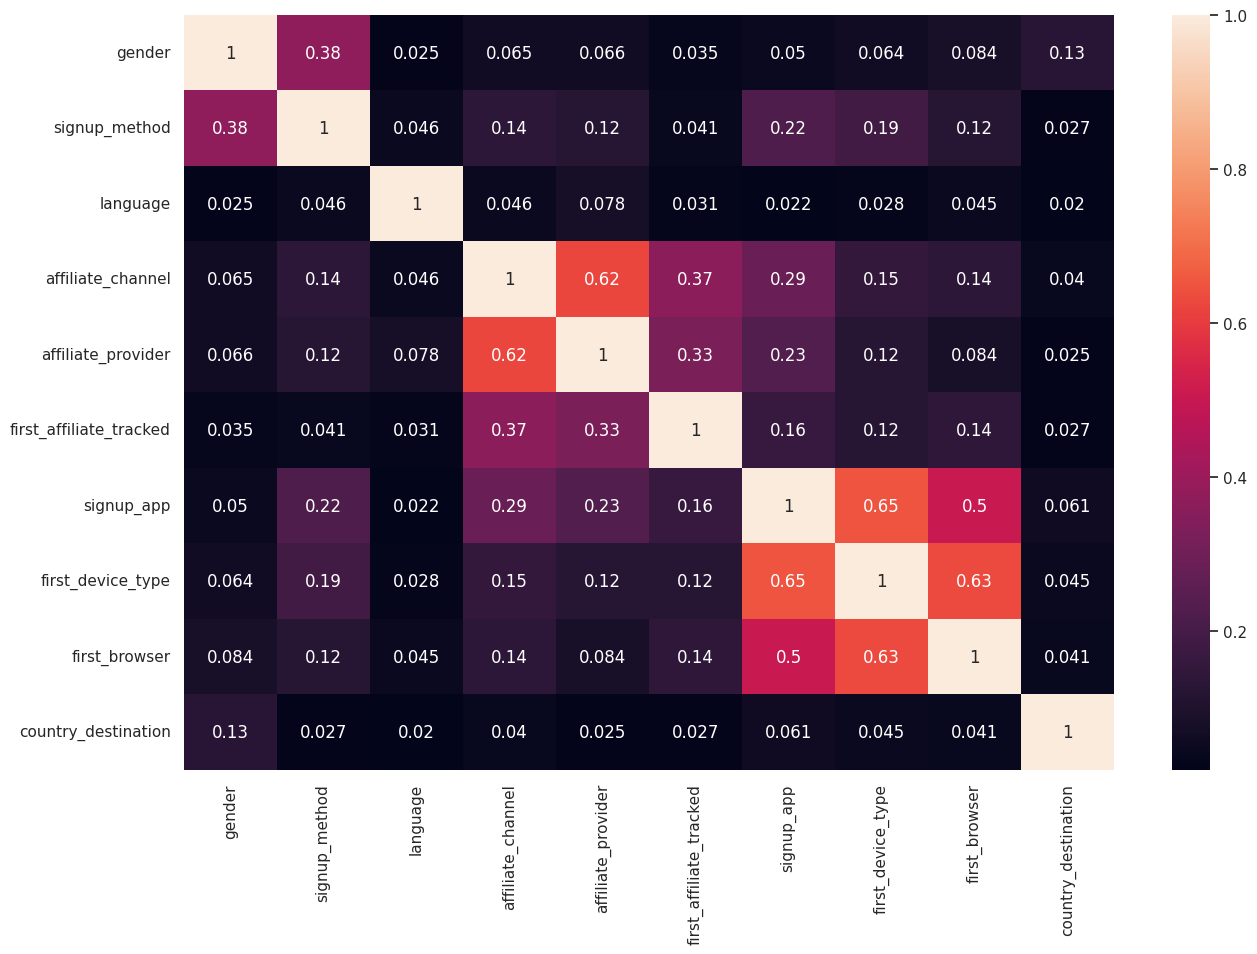

In [203]:
sns.set(rc= {'figure.figsize': (15,10)})
sns.heatmap(d, annot=True)

### Data Session

In [204]:
cat_atributes_session.describe().T

,count,unique,top,freq
user_id,9213930,133878,mxqbh3ykxl,2713
action,9213930,347,show,2178382
action_type,9213930,10,view,3545621
action_detail,9213930,155,view_search_results,1770931
device_type,9213930,14,Mac Desktop,3019523


In [205]:
l1  = cramer_v(cat_atributes_session['action'], cat_atributes_session['action'])
l2  = cramer_v(cat_atributes_session['action'], cat_atributes_session['action_type'])
l3  = cramer_v(cat_atributes_session['action'], cat_atributes_session['action_detail'])
l4  = cramer_v(cat_atributes_session['action'], cat_atributes_session['device_type'])

m1  = cramer_v(cat_atributes_session['action_type'], cat_atributes_session['action'])
m2  = cramer_v(cat_atributes_session['action_type'], cat_atributes_session['action_type'])
m3  = cramer_v(cat_atributes_session['action_type'], cat_atributes_session['action_detail'])
m4  = cramer_v(cat_atributes_session['action_type'], cat_atributes_session['device_type'])

n1  = cramer_v(cat_atributes_session['action_detail'], cat_atributes_session['action'])
n2  = cramer_v(cat_atributes_session['action_detail'], cat_atributes_session['action_type'])
n3  = cramer_v(cat_atributes_session['action_detail'], cat_atributes_session['action_detail'])
n4  = cramer_v(cat_atributes_session['action_detail'], cat_atributes_session['device_type'])

o1  = cramer_v(cat_atributes_session['device_type'], cat_atributes_session['action'])
o2  = cramer_v(cat_atributes_session['device_type'], cat_atributes_session['action_type'])
o3  = cramer_v(cat_atributes_session['device_type'], cat_atributes_session['action_detail'])
o4  = cramer_v(cat_atributes_session['device_type'], cat_atributes_session['device_type'])

In [206]:
cat = pd.DataFrame({'action': [l1, l2, l3, l4]
                ,'action_type': [m1,m2,m3,m4]
                ,'action_detail': [n1,n2,n3,n4]
                ,'device_type': [o1,o2,o3,o4]
})

cat= cat.set_index(cat.columns)

<AxesSubplot:>

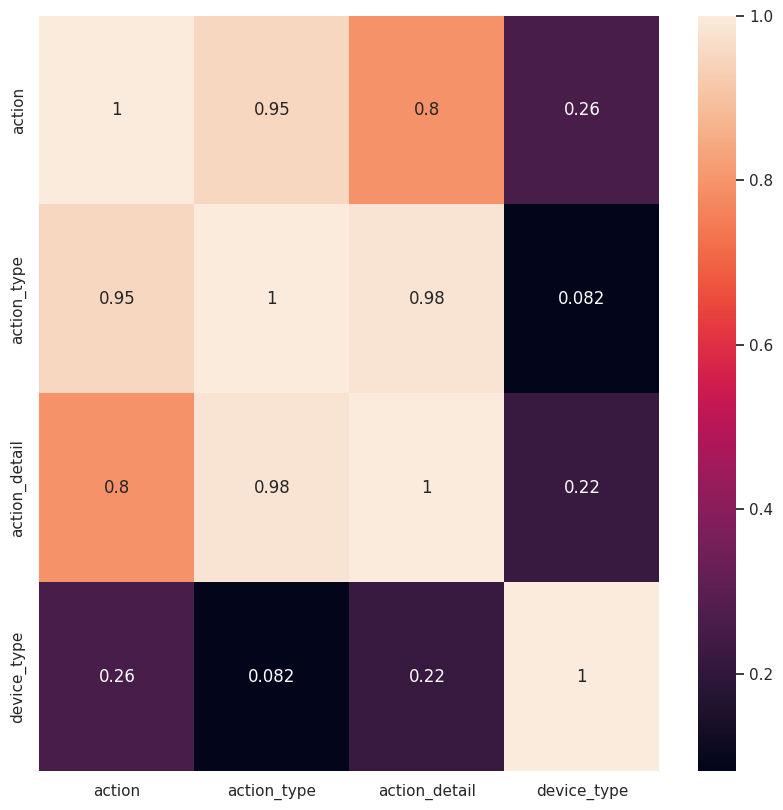

In [207]:
sns.set(rc= {'figure.figsize': (10,10)})
sns.heatmap(cat, annot=True)

## 4.3 Columns Selection

In [209]:
data.head(1).T

,0
gender,-unknown-
age,49
signup_method,facebook
signup_flow,0
language,en
affiliate_channel,direct
affiliate_provider,direct
first_affiliate_tracked,untracked
signup_app,Web
first_device_type,Mac Desktop


# 5.0 Exploratory data analysis

In [210]:
pass

# 6.0 Data Preparation (Encoder Variables)

In [253]:
data1 = data.copy()

In [254]:
data1.head(5)

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,date_first_booking_year,date_account_created_month,timestamp_first_active_month,date_first_booking_month,date_account_created_week,timestamp_first_active_week,date_first_booking_week,date_account_created_day,timestamp_first_active_day,date_first_booking_day
0,gxn3p5htnn,-unknown-,49,facebook,0,en,direct,direct,untracked,Web,...,2015,6,9,6,0,1,0,28,3,29
1,820tgsjxq7,MALE,38,facebook,0,en,seo,google,untracked,Web,...,2015,5,9,6,2,1,0,25,5,29
2,4ft3gnwmtx,FEMALE,56,basic,3,en,direct,direct,untracked,Web,...,2010,9,9,8,1,6,0,28,6,2
3,bjjt8pjhuk,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,...,2012,12,9,9,0,2,5,5,10,8
4,87mebub9p4,-unknown-,41,basic,0,en,direct,direct,untracked,Web,...,2010,9,9,2,1,4,3,14,12,18


## 6.1 Encoder Categorical Variable

In [259]:
ohe = pp.OneHotEncoder()

#Excluir Variavel resposta

#Numerical
col_num = data1.select_dtypes( include= ['int64', 'float64']).columns.tolist()

#Categorical
col_cat = data1.select_dtypes( exclude= ['int64', 'float64', 'datetime64[ns]']).drop( ['id','country_destination'], axis=1).columns.tolist()

#Encoding
df_dumy = pd.DataFrame(ohe.fit_transform(data1[ col_cat ]).toarray(), index=data1.index)

#Join numerical and categorical
data2 = pd.concat([data1[ col_num], df_dumy], axis=1)

# 7.0 Balanced Dataset

In [95]:
data_balanced = data.copy()

## 6.1 Random Undersampling

In [96]:
from imblearn import under_sampling as us

##### sampling_strategy

- 'majority': resample only the majority class; Mostra apenas a classe majoritária

- 'not minority': resample all classes but the minority class; Mostra a todas as classes exceto a minoritaria

- 'not majority': resample all classes but the majority class; Mostra a todas as classes exceto a majoritária

- 'all': resample all classes; Mostra a todas as classes

- 'auto': equivalent to 'not minority'.

In [260]:
#Define sampler
undersampling = us.RandomUnderSampler( sampling_strategy='auto', random_state=32) #Definir qual estrategia vai usar.

#Apply sampler
X_under, y_under = undersampling.fit_resample(data2, data_balanced['country_destination'])


In [261]:
data_balanced['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [262]:
y_under.value_counts()

AU       213
CA       213
DE       213
ES       213
FR       213
GB       213
IT       213
NDF      213
NL       213
PT       213
US       213
other    213
Name: country_destination, dtype: int64

## 6.2 Random Oversampling

In [110]:
from imblearn import over_sampling as over

In [263]:
#Define sampler
oversampling = over.RandomOverSampler( sampling_strategy='auto', random_state=32) #Definir qual estrategia vai usar.

#Apply sampler
X_over, y_over = oversampling.fit_resample(data2, data_balanced['country_destination'])


In [264]:
data_balanced['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [265]:
y_over.value_counts()

NDF      119810
US       119810
other    119810
CA       119810
FR       119810
ES       119810
GB       119810
IT       119810
PT       119810
NL       119810
DE       119810
AU       119810
Name: country_destination, dtype: int64

## 6.3 SMOTE + TOMELINK

In [116]:
from imblearn import combine as c

In [279]:
len(data['country_destination'])

206593

In [285]:
60800 / 4881

12.456463839377177

In [321]:
#Podemos criar um balanceamente entre as classes manualmente para que elas não fiquem todas com o mesmo valor, pois não precisamos ter exatamente todas as classes com o mesmo valor e dessa forma os dados ficam
#mais reais do que temos atualmente. Tentando evitar o overfitting do modelo.

ratio_balanced = {'NDF':       119810,
                  'US':   1.9 * 60800,
                  'other': 11 * 9935,
                  'FR':    24 * 4881,
                  'IT':    40 * 2776,
                  'GB':    45 * 2285,
                  'ES':    45 * 2203,
                  'CA':    71 * 1385,
                  'DE':    95 * 1033,
                  'NL':   130 * 746,
                  'AU':   180 * 526,
                  'PT':   440 * 213}

ratio_balanced

{'NDF': 119810,
 'US': 115520.0,
 'other': 109285,
 'FR': 117144,
 'IT': 111040,
 'GB': 102825,
 'ES': 99135,
 'CA': 98335,
 'DE': 98135,
 'NL': 96980,
 'AU': 94680,
 'PT': 93720}

In [266]:
smt = c.SMOTETomek( sampling_strategy='auto', random_state=32, n_jobs=-1) #No lugar do Auto, colocar o Ratio_balanced e testar a performance

#Apply sampler
X_smt, y_smt = smt.fit_resample( data2, data_balanced['country_destination'])

In [271]:
#Encodar os dados de volta, pois foi preciso encodar para utilizar o SMOTE.

#numerical data
df_aux1 = X_smt[col_num]

#Categorical data
df_aux2 = X_smt.drop(col_num, axis=1)

#Encodando
df_aux3 = pd.DataFrame(ohe.inverse_transform( df_aux2), columns= col_cat, index=  df_aux2.index)

#Join numerical categorical
df_final = pd.concat( [df_aux3, df_aux1 ], axis= 1)
df_final['country_destination'] = y_smt

In [322]:
#Df final com o balanceamento
df_final.to_csv(path_data+'ciclo005_balanced_dataset.csv', index=False)

# 8.0 Feature Selection

In [324]:
data = pd.read_csv(path_data+'ciclo005_balanced_dataset.csv')

data.head()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,age,...,date_account_created_month,timestamp_first_active_month,date_first_booking_month,date_account_created_week,timestamp_first_active_week,date_first_booking_week,date_account_created_day,timestamp_first_active_day,date_first_booking_day,country_destination
0,-unknown-,facebook,en,direct,direct,untracked,Web,Mac Desktop,Chrome,49,...,6,9,6,0,1,0,28,3,29,NDF
1,MALE,facebook,en,seo,google,untracked,Web,Mac Desktop,Chrome,38,...,5,9,6,2,1,0,25,5,29,NDF
2,FEMALE,basic,en,direct,direct,untracked,Web,Windows Desktop,IE,56,...,9,9,8,1,6,0,28,6,2,US
3,FEMALE,facebook,en,direct,direct,untracked,Web,Mac Desktop,Firefox,42,...,12,9,9,0,2,5,5,10,8,other
4,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,41,...,9,9,2,1,4,3,14,12,18,US


In [330]:
#GetDummies values (Para uso da Rede Neural precisamos preparar os dados dessa forma)

data_preparation_dummies = pd.get_dummies(data.drop(['country_destination'], axis=1))

# Jooin id And country destination
data_preparation_final = pd.concat( [data[['country_destination']], data_preparation_dummies], axis=1)

In [331]:
X = data_preparation_final.drop('country_destination', axis=1)
y = data_preparation_final['country_destination'].copy()

In [332]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=32)

In [334]:
ohe = pp.OneHotEncoder()

y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1)).toarray()

# 9.0 Machine Learning Model

### Baseline Model

In [335]:
country_destination_list = data_preparation_final['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_val.shape[0]
country_destination_weights = data_preparation_final['country_destination'].value_counts( normalize=True).sort_index().tolist()

#Modelo Aleatório
yhat_random = random.choices( population=country_destination_list, k=k_num, weights=country_destination_weights)

Accuracy: 0.0836812653000108
Balanced Accuracy: 0.08368698200561402
Kappa Score: 0.000381076874745534


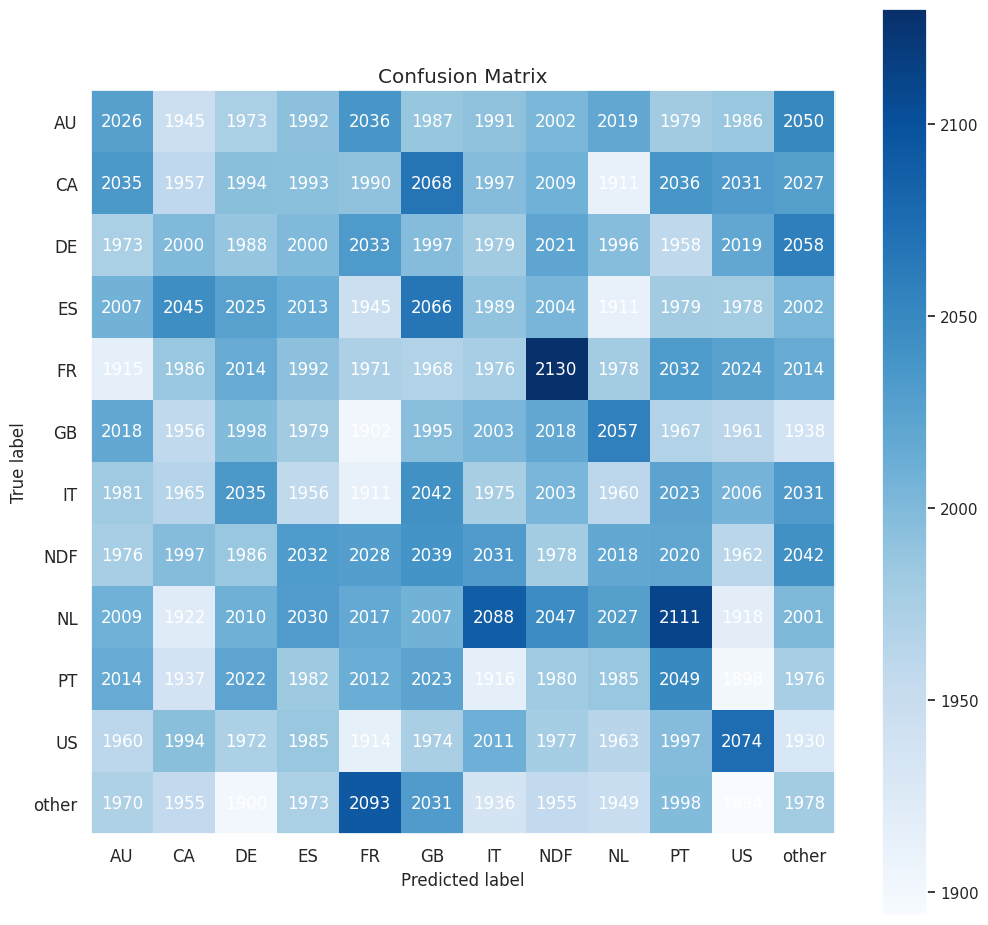

In [336]:
#Accuracy
acc_random = m.accuracy_score(y_val, yhat_random)
print('Accuracy: {}'.format(acc_random))

#Confusion Matrix
mt.plot_confusion_matrix( y_val, yhat_random, normalize= False, figsize=(12,12))

#Balanced Accuracy
balanced_accuracy_random = m.balanced_accuracy_score(y_val, yhat_random )
print('Balanced Accuracy: {}'.format(balanced_accuracy_random))

#Kappa Metrics
kappa_score_random = m.cohen_kappa_score(y_val, yhat_random)
print('Kappa Score: {}'.format(kappa_score_random))

#Objetivo é aumentar o Balanced Accuracy para uns 85% (Acuracia para apresentar ao time de negocio
#Kappa Score uns 75% (Nivel de concordancia entre as classes).

#print(m.classification_report(y_val_nn, yhat_nn))

### Neural Network MLP

In [338]:
##Model Definition
#model = ml.Sequential()
#
#model.add( l.Dense(128, input_dim=X_train.shape[1], activation= 'relu'))
#model.add( l.Dense( 12, activation = 'softmax'))
#
##model Compile
#model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#
##Train model
#model.fit( X_train, y_train_nn, epochs=100)

Epoch 1/100


2022-11-28 18:24:35.492807: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1350858264 exceeds 10% of free system memory.


35897/35897 [==============================] - 21s 587us/step - loss: 4.6465 - accuracy: 0.1734
Epoch 2/100
35897/35897 [==============================] - 21s 589us/step - loss: 2.2001 - accuracy: 0.1674
Epoch 3/100
35897/35897 [==============================] - 21s 590us/step - loss: 2.1993 - accuracy: 0.1672
Epoch 4/100
35897/35897 [==============================] - 21s 590us/step - loss: 2.1990 - accuracy: 0.1673
Epoch 5/100
35897/35897 [==============================] - 21s 590us/step - loss: 2.1988 - accuracy: 0.1673
Epoch 6/100
35897/35897 [==============================] - 21s 589us/step - loss: 2.1987 - accuracy: 0.1672
Epoch 7/100
35897/35897 [==============================] - 21s 589us/step - loss: 2.1987 - accuracy: 0.1669
Epoch 8/100
35897/35897 [==============================] - 21s 590us/step - loss: 2.1987 - accuracy: 0.1667
Epoch 9/100
35897/35897 [==============================] - 21s 591us/step - loss: 2.1987 - accuracy: 0.1669
Epoch 10/100
35897/35897 [==============

In [342]:
#Salvando o treinamento em um arquico compactado
#pickle.dump(model, open(path_model+'ciclo005_model_NLP.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://afcefedb-338d-49df-959d-5935c780b222/assets


In [346]:
model = pickle.load(open(path_model+'ciclo005_model_NLP.pkl', 'rb'))

#Prediction
pred_nn = model.predict(X_val)

#Invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

#Prediction prepare
y_val_nn = y_val.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

 225/8975 [..............................] - ETA: 3s

2022-11-28 19:18:17.825424: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 337715448 exceeds 10% of free system memory.


8975/8975 [==============================] - 4s 432us/step


Accuracy: 0.1675401238974416
Balanced Accuracy: 0.1666807011634598
Kappa Score: 0.0915925914932898


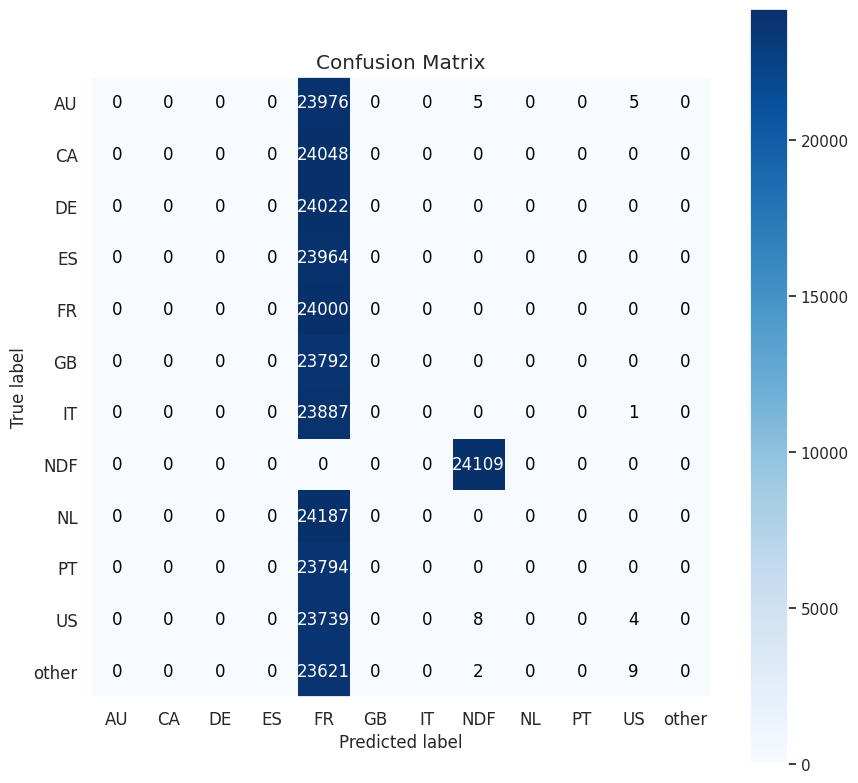

In [347]:
#Accuracy
acc_nn = m.accuracy_score(y_val_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

#Confusion Matrix
mt.plot_confusion_matrix( y_val_nn, yhat_nn, normalize= False, figsize=(10,10))

#Balanced Accuracy
balanced_accuracy = m.balanced_accuracy_score(y_val_nn, yhat_nn )
print('Balanced Accuracy: {}'.format(balanced_accuracy))

#Kappa Metrics
kappa_score = m.cohen_kappa_score(y_val_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_score))

#Objetivo é aumentar o Balanced Accuracy para uns 85% (Acuracia para apresentar ao time de negocio
#Kappa Score uns 75% (Nivel de concordancia entre as classes).

#print(m.classification_report(y_val_nn, yhat_nn))